In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Human Protein Classification with Fastai v1

In [2]:
#!conda uninstall --force jpeg libtiff -y

In [3]:
#!conda install -c conda-forge libjpeg-turbo

In [4]:
#!CC="cc -mavx2" pip install --no-cache-dir -U --force-reinstall --no-binary :all: --compile pillow-simd

In [5]:
import os
from pathlib import Path
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from fastai import *
from fastai.vision import *

from utils import open_4_channel
from dataset import ImageMulti4Channel
from resnet import Resnet4Channel

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
#from skmultilearn.model_selection import IterativeStratification, iterative_train_test_split
from scipy.optimize import minimize, fmin
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

import scipy.optimize as opt

In [6]:
from fastai import utils

In [7]:
utils.show_install()



```text
=== Software === 
python version  : 3.7.0
fastai version  : 1.0.20
torch version   : 1.0.0.dev20181108
nvidia driver   : 396.54
torch cuda ver  : 9.2.148
torch cuda is   : available
torch cudnn ver : 7104
torch cudnn is  : enabled

=== Hardware === 
nvidia gpus     : 1
torch available : 1
  - gpu0        : 8116MB | GeForce GTX 1080

=== Environment === 
platform        : Linux-4.15.0-43-generic-x86_64-with-debian-buster-sid
distro          : #46-Ubuntu SMP Thu Dec 6 14:45:28 UTC 2018
conda env       : fastai
python          : /home/dollofcuty/anaconda3/envs/fastai/bin/python
sys.path        : 
/media/dollofcuty/E604249504246B2F/Users/chrun/Documents/Projects/dollofcutyprotein
/home/dollofcuty/anaconda3/envs/fastai/lib/python37.zip
/home/dollofcuty/anaconda3/envs/fastai/lib/python3.7
/home/dollofcuty/anaconda3/envs/fastai/lib/python3.7/lib-dynload
/home/dollofcuty/anaconda3/envs/fastai/lib/python3.7/site-packages
/home/dollofcuty/anaconda3/envs/fastai/lib/python3.7/site-packag

In [8]:
np.random.seed(21)

In [9]:
path = Path('data/')

In [10]:
df = pd.read_csv(path/'train.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [11]:
df_external = pd.read_csv('external/external.csv')
df_external.head()

,Id,Target
0,10580_1610_C1_1,13 25 0 2 21
1,10580_1610_C1_2,13 25 0 2 21
2,10580_1756_B1_1,13 25 0 2 21
3,10580_1756_B1_2,13 25 0 2 21
4,10580_1758_B1_1,13 25 0 2 21


In [12]:
highest_ratio = df['Target'].value_counts()[df['Target'].value_counts()>1000].index.tolist()
highest_ratio

['0', '25 0', '23', '25', '7', '4', '21']

In [13]:
df_external = df_external[~df_external['Target'].isin(highest_ratio)]

In [14]:
len(df), len(df_external)

(31072, 36291)

In [15]:
train_df_orig = df.copy()    

lows = [15,15,15,8,9,10,8,9,10,8,9,10,17,20,24,26,15,27,15,20,24,17,8,15,27,27,27]

for i in lows:
    target = str(i)
    indicies = train_df_orig.loc[train_df_orig['Target'] == target].index
    df = pd.concat([df,train_df_orig.loc[indicies]], ignore_index=True)
    indicies = train_df_orig.loc[train_df_orig['Target'].str.startswith(target+" ")].index
    df = pd.concat([df,train_df_orig.loc[indicies]], ignore_index=True)
    indicies = train_df_orig.loc[train_df_orig['Target'].str.endswith(" "+target)].index
    df = pd.concat([df,train_df_orig.loc[indicies]], ignore_index=True)
    indicies = train_df_orig.loc[train_df_orig['Target'].str.contains(" "+target+" ")].index
    df = pd.concat([df,train_df_orig.loc[indicies]], ignore_index=True)

In [16]:
df_complete = df.append(df_external).reset_index(drop=True)

In [17]:
len(df), len(df_external), len(df_complete)

(33409, 36291, 69700)

### get better validation split since the classes are very unevenly represented

In [18]:
subcell_locs = {
    0:  "Nucleoplasm", 
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center" ,  
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",
    8:  "Peroxisomes",
    9:  "Endosomes",
    10:  "Lysosomes",
    11:  "Intermediate filaments",   
    12:  "Actin filaments",
    13:  "Focal adhesion sites",   
    14:  "Microtubules",
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",
    18:  "Microtubule organizing center",  
    19:  "Centrosome",
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions", 
    23:  "Mitochondria",
    24:  "Aggresome",
    25:  "Cytosol",
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings" 
}

In [19]:
def plot_ratio(targets):
    labels_num = [value.split() for value in targets]
    labels_num_flat = list(map(int, [item for sublist in labels_num for item in sublist]))
    labels = ["" for _ in range(len(labels_num_flat))]
    for i in range(len(labels_num_flat)):
        labels[i] = subcell_locs[labels_num_flat[i]]

    fig, ax = plt.subplots(figsize=(15, 5))
    pd.Series(labels).value_counts().plot('bar', fontsize=14)

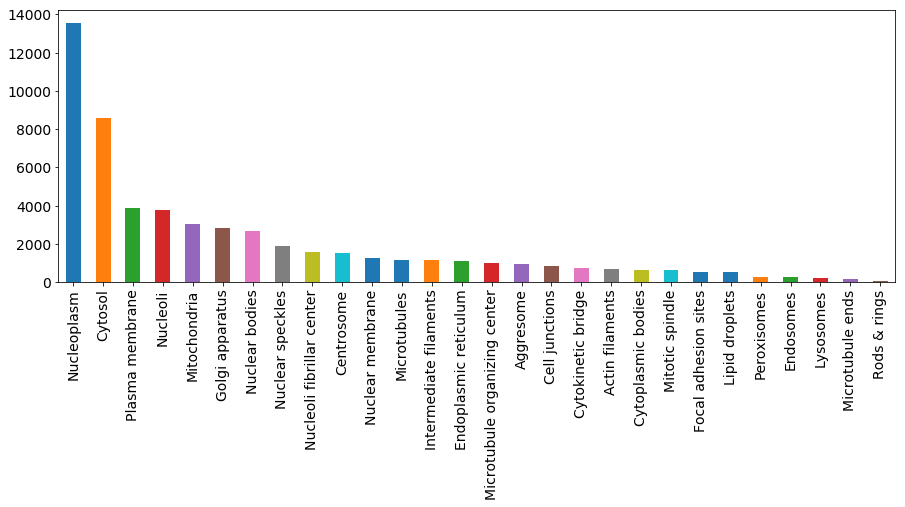

In [20]:
plot_ratio(df['Target'])

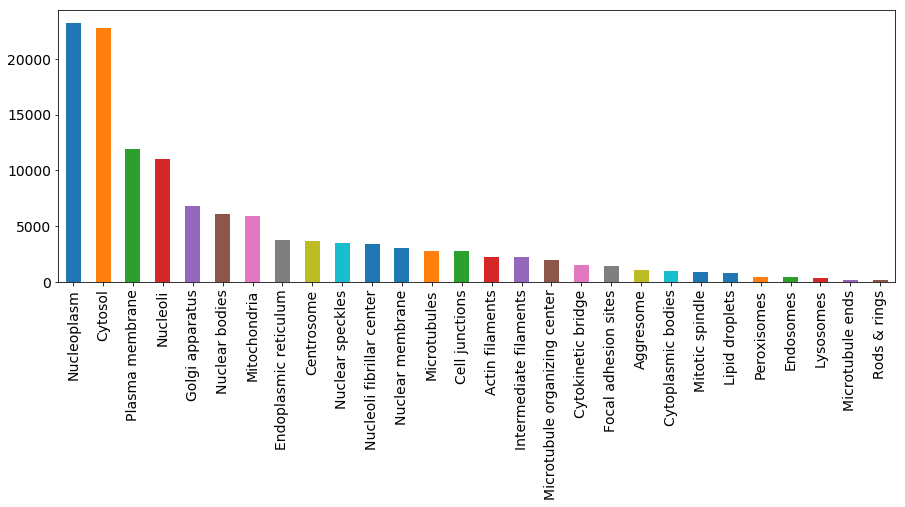

In [21]:
plot_ratio(df_complete['Target'])

In [22]:
class Fold:
    def __init__(self, trn_id, val_id):
        self.train_index = trn_id
        self.val_index = val_id

In [23]:
#k_fold = IterativeStratification(n_splits=5, order=1, random_state=21)
#    
#train_df_orig = df.copy()
#    
#X = train_df_orig['Id'].tolist()
#y = train_df_orig['Target'].tolist()
#y = MultiLabelBinarizer().fit_transform(y)
#folds = []
#
#for train_index, val_index in k_fold.split(X, y):
#    print("Train:", len(train_index), "Valid:", len(val_index))
#    fold = Fold(train_index, val_index)
#    folds.append(fold)
#    #folds[i] = np.append(train_index, val_index)
#   
#del X, y
#gc.collect()

In [24]:
#np.save(path/'folds', folds)

In [25]:
#folds = np.load(path/'folds.npy')

In [26]:
#train_index = folds[0].train_index
#val_index = folds[0].val_index

In [27]:
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42) #random_state=42
train_df_orig = df.copy() #df

train_df_orig['Target'] = train_df_orig.apply(lambda x: x['Target'].split(' '), axis=1)

X = train_df_orig['Id'].tolist()
y = train_df_orig['Target'].tolist()
y = MultiLabelBinarizer().fit_transform(y)

for train_index, val_index in msss.split(X,y): #it should only do one iteration
    print("Train:", train_index, "Valid:", val_index)

del X, y
gc.collect()

Train: [    0     1     2     3 ... 33405 33406 33407 33408] Valid: [    9    13    24    40 ... 33370 33380 33399 33400]


2

In [28]:
train_index = np.append(train_index, [i for i in range(len(df), len(df_complete))])
len(train_index), len(val_index), len(df_complete)

(66308, 3392, 69700)

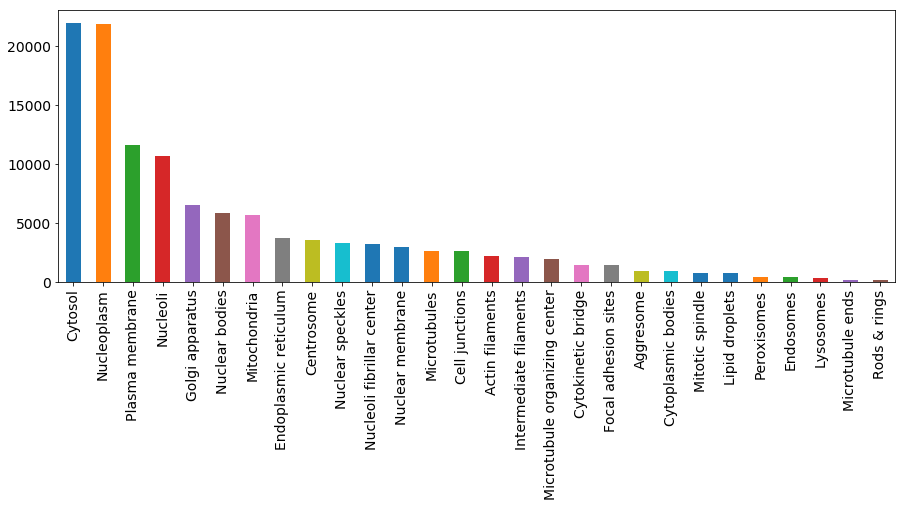

In [29]:
plot_ratio(df_complete.loc[train_index]['Target'])

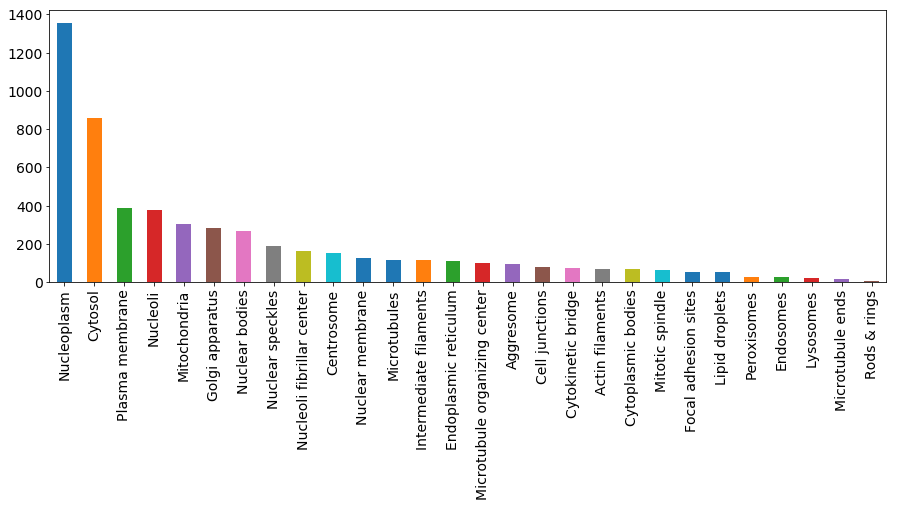

In [30]:
plot_ratio(df_complete.loc[val_index]['Target'])

### set everything we need for creating a ImageMultiDataset

In [31]:
fns = pd.Series([id for id in df_complete.Id])
labels = [targ.split(' ') for targ in df_complete.Target]
classes=[str(i) for i in range(28)]

In [32]:
trn_mask=[]

for i in range(len(df_complete)):
    trn_mask.append(False if i in val_index else True)
    
len(trn_mask), trn_mask.count(True), trn_mask.count(False)

(69700, 66308, 3392)

### create train, valid and test ImageMultiDataset

In [33]:
trn_ds, val_ds = ImageMulti4Channel.from_folder_validx(path, 'train', trn_mask, fns, labels, classes=classes)
trn_ds, val_ds

(ImageMulti4Channel of len 66308, ImageMulti4Channel of len 3392)

In [34]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))

In [35]:
test_ds,_ = ImageMulti4Channel.from_folder(
    path, 'test', pd.Series(test_ids),[['0'] for _ in range(len(test_ids))], valid_pct=0, classes=['0'])

### Calculate mean/std for this dataset

In [36]:
#means = torch.zeros(4)
#stds = torch.zeros(4)

In [37]:
#count = len(fns) 
#count

In [38]:
#means = torch.zeros(3)
#stds = torch.zeros(3)

#import PIL
#
#colors = ['red','green','blue','yellow']
#
#for fname in fns:
#    channels = [PIL.Image.open('data/train/'+fname+'_'+color+'.jpg') for color in colors]
#    x = np.stack(channels, axis=-1)    
#    
#    img = Image(pil2tensor(x,np.float32).div_(255)).data
#    
#    means += torch.Tensor([torch.mean(img[0]), torch.mean(img[1]), torch.mean(img[2]), torch.mean(img[3])])
#    stds += torch.Tensor([torch.std(img[0]), torch.std(img[1]), torch.std(img[2]), torch.std(img[3])])
  
#for fname in test_ids:
#    channels = [open_image('data/test/'+fname+'_'+color+'.png', convert_mode='L').data for color in colors]
#    
#    stack = np.stack(channels, axis=-1)
#    img = Image(pil2tensor(stack[0,:,:], np.float32).float()).data
#    
#    means += torch.Tensor([torch.mean(img[0]), torch.mean(img[1]), torch.mean(img[2]), torch.mean(img[3])])
#    stds += torch.Tensor([torch.std(img[0]), torch.std(img[1]), torch.std(img[2]), torch.std(img[3])])

#mean = means/count
#std = stds/count
#mean, std

### define transforms, normalization and metric

In [39]:
get_transforms

<function fastai.vision.transform.get_transforms(do_flip: bool = True, flip_vert: bool = False, max_rotate: float = 10.0, max_zoom: float = 1.1, max_lighting: float = 0.2, max_warp: float = 0.2, p_affine: float = 0.75, p_lighting: float = 0.75, xtra_tfms: Union[Collection[fastai.vision.image.Transform], NoneType] = None) -> Collection[fastai.vision.image.Transform]>

In [40]:
#trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=10., max_zoom=1.1,
#                      max_lighting=0.2, max_warp=0.2)

In [41]:
trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1.,
                      max_lighting=0.2, max_warp=0.)

In [42]:
#lafoss normalization
#stats_train = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

#with external, without testset, oversampling with external, without majority classes:
#stats_train = ([0.0563, 0.0465, 0.0292, 0.0897], [0.0853, 0.0708, 0.0736, 0.1305])

#with external, without testset, oversampling without external, without majority classes:
stats_train = ([0.0574, 0.0475, 0.0305, 0.0894], [0.0873, 0.0721, 0.0766, 0.1303])

#with external and test set:
#stats_train = ([0.0574, 0.0478, 0.0311, 0.0848], [0.0899, 0.0748, 0.0793, 0.1265]) 

#with external without majority classes:
#stats_train = ([0.0571, 0.0483, 0.0294, 0.0892],[0.0875, 0.0739, 0.0745, 0.1314])

## define functions for model

In [43]:
def resnet34(pretrained=True):
    return Resnet4Channel(encoder_depth=34, pretrained=pretrained)

def resnet50(pretrained=True):
    return Resnet4Channel(encoder_depth=50, pretrained=pretrained)

def resnet101(pretrained=True):
    return Resnet4Channel(encoder_depth=101, pretrained=pretrained)

def resnet152(pretrained=True):
    return Resnet4Channel(encoder_depth=152, pretrained=pretrained)

In [44]:
@dataclass
class TrackerCallback(LearnerCallback):
    "A `LearnerCallback` that keeps track of the best value in `monitor`."
    monitor:str='val_loss'
    mode:str='auto'
    
    def __post_init__(self):
        if self.mode not in ['auto', 'min', 'max']:
            warn(f'{self.__name__} mode {self.mode} is invalid, falling back to "auto" mode.')
            self.mode = 'auto'
        mode_dict = {'min': np.less, 'max':np.greater}
        mode_dict['auto'] = np.less if 'loss' in self.monitor else np.greater
        self.operator = mode_dict[self.mode]
    
    def on_train_begin(self, **kwargs:Any)->None:
        self.best = float('inf') if self.operator == np.less else -float('inf')
    
    def get_monitor_value(self):
        values = {'trn_loss':self.learn.recorder.losses[-1:][0].cpu().numpy(),
                  'val_loss':self.learn.recorder.val_losses[-1:][0]}
        for i, name in enumerate(self.learn.recorder.names[3:]):
            values[name]=learn.recorder.metrics[-1:][0][i] 
        if values.get(self.monitor) is None:
            warn(f'{self.__name__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:]))}')   
        return values.get(self.monitor)

In [45]:
@dataclass
class SaveModel(TrackerCallback):
    "A `LearnerCallback` that saves the model when monitored quantity is best."
    every:str='improvement'
    name:str='bestmodel'
    def __post_init__(self):
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
        super().__post_init__()
   
    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        if self.every=="epoch": learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                self.best = current
                learn.save(f'{self.name}')
    
    def on_train_end(self, **kwargs):
        if self.every=="improvement": learn.load(f'{self.name}')

In [46]:
def _resnet_split(m:nn.Module): return (m[0][6],m[1])

In [47]:
weights = torch.tensor([0.5, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.2, 0.2, 0.2, 0.4, 0.4, 0.4, 0.4, 0.2, 0.4, \
                        0.4, 0.4, 0.4, 0.2, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.2])

#for loss weights: .to(torch.device("cuda"))

In [48]:
f1 = partial(fbeta, thresh=0.4, beta=1) #thresh=weights

In [49]:
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

In [50]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2): #gamma=4 working pretty bad
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

### create ImageDataBunch from all this

In [51]:
torch.backends.cudnn.benchmark = True
src_size = 1024

In [52]:
bs = 64

In [53]:
data = ImageDataBunch.create(trn_ds, val_ds, test_ds=test_ds, path=path, bs=bs, ds_tfms=(trn_tfms, []), \
                             num_workers=8, size=256).normalize(stats_train)

In [54]:
data.train_ds, data.valid_ds

(DatasetTfm(ImageMulti4Channel of len 66308),
 DatasetTfm(ImageMulti4Channel of len 3392))

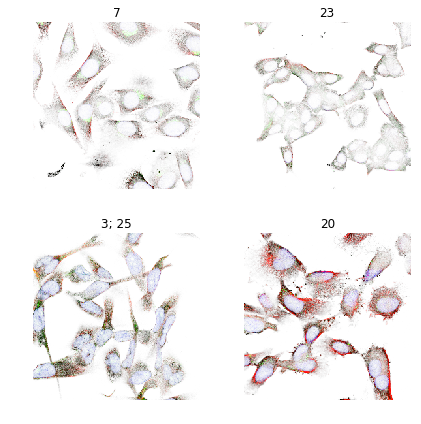

In [55]:
data.show_batch(rows=2, figsize=(6,6), ds_type=DatasetType.Valid)

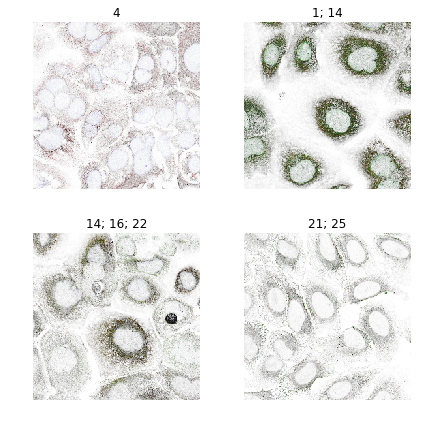

In [56]:
data.show_batch(rows=2, figsize=(6,6))

### create model and learner

In [58]:
learn = create_cnn(
    data,
    resnet50,
    ps=[0.5, 0.5],
    cut=-2,
    split_on=_resnet_split, 
    path=path,    
    metrics=[f1,acc],
    callback_fns=[ShowGraph] #, BnFreeze
)

In [59]:
learn.loss_func = FocalLoss()

In [60]:
learn.clip = 1.0 #gradient clipping

In [61]:
learn.loss_func, learn.opt_func

(FocalLoss(),
 functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)))

In [62]:
learn.layer_groups

[Sequential(
   (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (10): ReLU(inplace)
   (11): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (13): Conv2d(256, 64, kernel_

In [63]:
learn.freeze()

In [64]:
apply_init(learn.model[1], nn.init.kaiming_normal_)

### use lr find to get a good learning rate

In [65]:
learn.data.train_ds, learn.data.valid_ds

(DatasetTfm(ImageMulti4Channel of len 66308),
 DatasetTfm(ImageMulti4Channel of len 3392))

In [66]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


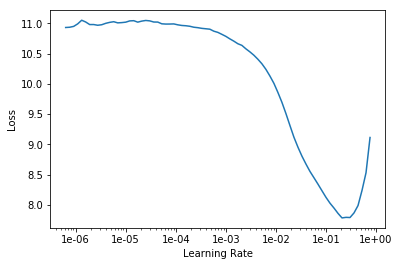

In [67]:
learn.recorder.plot() 

In [68]:
lr = 1e-3

### fit the model (half image size)

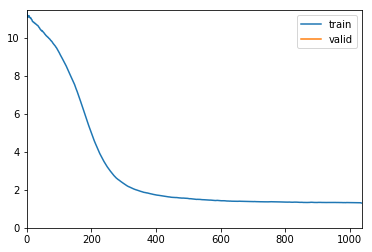

In [69]:
learn.fit_one_cycle(1, max_lr=slice(lr)) 

In [70]:
learn.save('256px_res50_frozen')

### unfreeze there resnet layers and train again 

In [71]:
learn.unfreeze()

In [72]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


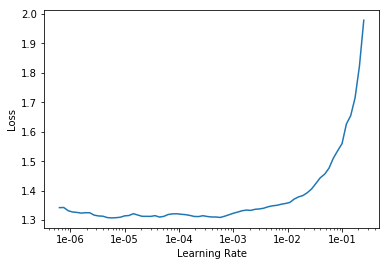

In [73]:
learn.recorder.plot()

In [74]:
learn.callback_fns.append(partial(SaveModel, every='improvement', monitor='val_loss'))

In [75]:
#lrs = slice(1e-5, 1e-4) 
lr = 2e-4
lrs = slice(lr/2, lr) 

In [76]:
learn.lr_range(lrs)

array([0.0001  , 0.000141, 0.0002  ])

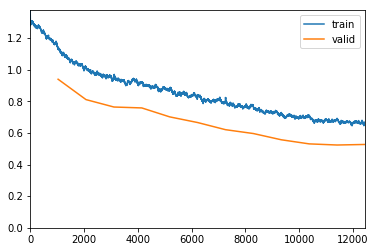

In [77]:
learn.fit_one_cycle(12, max_lr=lrs)

Total time: 3:29:04
epoch  train_loss  valid_loss  fbeta  acc        
1      1.202748    0.962311    0.524690  0.955987  (10:24)
2      1.103429    0.857867    0.588291  0.959809  (10:27)
3      1.021858    0.793653    0.633086  0.962616  (10:30)
4      0.950083    0.751949    0.661454  0.964527  (10:28)
5      0.913092    0.721398    0.670941  0.965967  (10:27)
6      0.882053    0.695050    0.689797  0.966995  (10:27)
7      0.855754    0.692536    0.688911  0.966908  (10:26)
8      0.830382    0.679160    0.695969  0.966972  (10:27)
9      0.775448    0.630242    0.714533  0.969732  (10:26)
10     0.740050    0.609070    0.732046  0.970645  (10:26)
11     0.705342    0.596182    0.732484  0.971344  (10:26)
12     0.671177    0.579997    0.742547  0.972154  (10:26)
13     0.655288    0.570264    0.746554  0.972429  (10:26)
14     0.602597    0.560704    0.751784  0.973273  (10:27)
15     0.572793    0.561216    0.754999  0.973216  (10:27)
16     0.563122    0.548458    0.761784  0.97

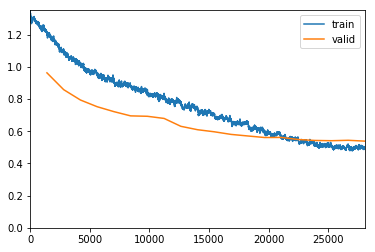

In [234]:
learn.fit_one_cycle(20, max_lr=lrs)

In [78]:
learn.save('256px_res50_unfrozen')

### train on 512px

In [52]:
bs = 12

In [53]:
data = ImageDataBunch.create(trn_ds, val_ds, test_ds=test_ds, path=path, bs=bs, ds_tfms=(trn_tfms, []), \
                             num_workers=8, size=512).normalize(stats_train)

In [54]:
learn = create_cnn(
    data,
    resnet50,
    ps=[0.5, 0.5],
    cut=-2,
    split_on=_resnet_split, 
    path=path,    
    metrics=[f1,acc],
    callback_fns=[ShowGraph] #, BnFreeze
)

In [55]:
learn.loss_func = FocalLoss()

In [56]:
learn.split(split_on=_resnet_split)

In [57]:
learn.clip = 1.0 #gradient clipping

In [58]:
learn.layer_groups

[Sequential(
   (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (10): ReLU(inplace)
   (11): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (13): Conv2d(256, 64, kernel_

In [59]:
learn.load('bestmodel')

In [60]:
learn.unfreeze()

In [61]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


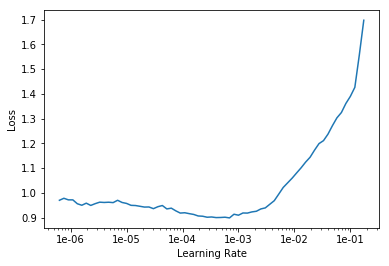

In [62]:
learn.recorder.plot()

In [63]:
learn.callback_fns.append(partial(SaveModel, every='improvement', monitor='val_loss'))

In [64]:
lr = 5e-5

lrs = slice(lr/2, lr)

In [65]:
learn.lr_range(lrs)

array([2.500000e-05, 3.535534e-05, 5.000000e-05])

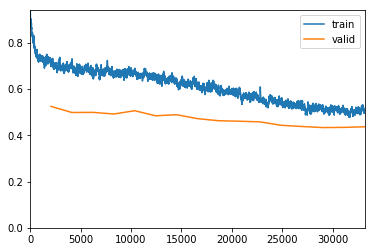

In [66]:
learn.fit_one_cycle(16, lrs, div_factor=10) #5e-5 slice(lr/2, lr/1) resnet50 

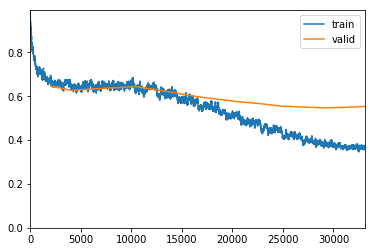

In [67]:
learn.fit_one_cycle(16, lrs, div_factor=25) #1e-4 slice(lr/2, lr/1) resnet50 

In [67]:
learn.save('512px_res50_unfrozen')

epoch,train_loss,valid_loss,fbeta,acc
1,0.763640,0.627220,0.739867,0.971098
2,0.689670,0.555548,0.758399,0.973415
3,0.675247,0.530419,0.766944,0.974401
4,0.649555,0.514674,0.777443,0.975548
5,0.630807,0.529527,0.773746,0.975376
6,0.633052,0.518559,0.778777,0.975342
7,0.631546,0.531495,0.776143,0.975066
8,0.628181,0.513561,0.776377,0.975766
9,0.609148,0.508847,0.782748,0.975858
10,0.597022,0.541191,0.773577,0.974734


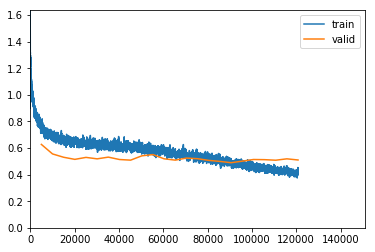

In [ ]:
learn.fit_one_cycle(30, lrs, div_factor=25) #5e-5 slice(lr/2, lr/1) resnet50 

## Train on 768px

In [52]:
#gc.collect()

In [53]:
bs = 12

In [54]:
data = ImageDataBunch.create(trn_ds, val_ds, test_ds=test_ds, path=path, bs=bs, ds_tfms=(trn_tfms, []), \
                             num_workers=16, size=768).normalize(stats_train)

In [55]:
learn = create_cnn(
    data,
    resnet50,
    ps=[0.5, 0.5],
    cut=-2,
    split_on=_resnet_split, 
    path=path,    
    metrics=[f1,acc],
    callback_fns=[ShowGraph] #, BnFreeze
)

In [56]:
learn.loss_func = FocalLoss()

In [57]:
learn.split(split_on=_resnet_split)

In [58]:
learn.clip = 1.0 #gradient clipping

In [59]:
learn.layer_groups

[Sequential(
   (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (10): ReLU(inplace)
   (11): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (13): Conv2d(256, 64, kernel_

In [60]:
learn.load('bestmodel_512px')

In [61]:
learn.unfreeze()

In [62]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


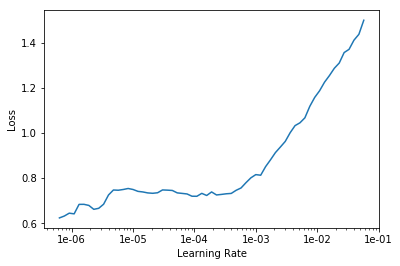

In [63]:
learn.recorder.plot()

In [64]:
learn.callback_fns.append(partial(SaveModel, every='epoch', monitor='val_loss'))

In [65]:
lr = 2e-5

lrs = slice(lr/2, lr)

In [66]:
learn.lr_range(lrs)

array([1.000000e-05, 1.414214e-05, 2.000000e-05])

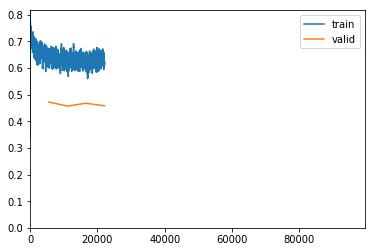

In [ ]:
learn.fit_one_cycle(18, lrs, div_factor=10) #5e-5 slice(lr/2, lr/1) resnet50 

In [ ]:
learn.save('768px_res50_unfrozen')

### Try to find a good Threshold

In [59]:
#learn.load('continued_1')
learn.load('bestmodel') #better

In [60]:
learn.model.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [61]:
preds_tta,y = learn.TTA(ds_type=DatasetType.Valid)

Total time: 06:27



In [62]:
act_preds = torch.sigmoid(preds_tta)

### threshold calculation

In [63]:
preds_np = preds_tta.numpy()
act_preds_np = act_preds.numpy()
y_np = y.numpy()

In [64]:
def f1_thresh_negative(thresh):
    return -f1_score((act_preds_np>thresh), y.numpy(), average='macro')

In [65]:
def f1_thresh(thresh):
    return f1_score((act_preds_np>thresh), y.numpy(), average='macro')

In [66]:
res = minimize(f1_thresh_negative, weights, method='Powell', options={'disp': True})

/home/dollofcuty/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Optimization terminated successfully.
         Current function value: -0.806140
         Iterations: 4
         Function evaluations: 4100


In [69]:
res = minimize(f1_thresh_negative, weights, method='Powell', options={'disp': True})

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Optimization terminated successfully.
         Current function value: -0.834951
         Iterations: 6
         Function evaluations: 6378


In [67]:
f1_thresh(res.x)

0.8061400902664655

In [68]:
#f1_thresh(res.x)

In [69]:
res.x

array([0.418299, 0.271652, 0.396429, 0.458656, 0.502188, 0.381796, 0.421115, 0.399115, 0.317505, 0.324908, 0.386648,
       0.246617, 0.394745, 0.4     , 0.288337, 0.103252, 0.340612, 0.24616 , 0.39726 , 0.370565, 0.330599, 0.391531,
       0.371235, 0.375003, 0.321778, 0.389362, 0.405002, 0.401099])

In [70]:
fbeta(act_preds, y, thresh=torch.from_numpy(res.x).float(), sigmoid=False)

tensor(0.7999)

In [71]:
## trying brians thresholding:

In [73]:
thresholds = np.linspace(0, 1, 1000)
score = 0.0
test_threshold=0.5*np.ones(28)
best_threshold=np.zeros(28)
best_val = np.zeros(28)
for i in range(28):
    for threshold in thresholds:
        test_threshold[i] = threshold
        max_val = np.max(act_preds_np)
        val_predict = (act_preds_np > test_threshold)
        score = f1_score(y_np > 0.5, val_predict, average='macro')
        if score > best_val[i]:
            best_threshold[i] = threshold
            best_val[i] = score
    print("Threshold[%d] %0.6f, F1: %0.6f" % (i,best_threshold[i],best_val[i]))
    test_threshold[i] = best_threshold[i]
print("Best threshold: ")
print(best_threshold)
print("Best f1:")
print(best_val)

/home/dollofcuty/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[0] 0.418418, F1: 0.742482
Threshold[1] 0.277277, F1: 0.745793
Threshold[2] 0.396396, F1: 0.747123
Threshold[3] 0.454454, F1: 0.747979
Threshold[4] 0.489489, F1: 0.748099
Threshold[5] 0.372372, F1: 0.750940
Threshold[6] 0.465465, F1: 0.751839
Threshold[7] 0.430430, F1: 0.753133
Threshold[8] 0.280280, F1: 0.755231
Threshold[9] 0.285285, F1: 0.758356
Threshold[10] 0.387387, F1: 0.759365
Threshold[11] 0.243243, F1: 0.765139
Threshold[12] 0.359359, F1: 0.766125
Threshold[13] 0.538539, F1: 0.766937
Threshold[14] 0.275275, F1: 0.770218
Threshold[15] 0.097097, F1: 0.771617
Threshold[16] 0.342342, F1: 0.776263
Threshold[17] 0.257257, F1: 0.784130
Threshold[18] 0.396396, F1: 0.788575
Threshold[19] 0.408408, F1: 0.792106
Threshold[20] 0.314314, F1: 0.794123
Threshold[21] 0.458458, F1: 0.795768
Threshold[22] 0.335335, F1: 0.798870
Threshold[23] 0.375375, F1: 0.801714
Threshold[24] 0.321321, F1: 0.805680
Threshold[25] 0.389389, F1: 0.808046
Threshold[26] 0.394394, F1: 0.809946
Threshold[2

Nucleoplasm 0 0.7452574525745258 0.4620187587392194


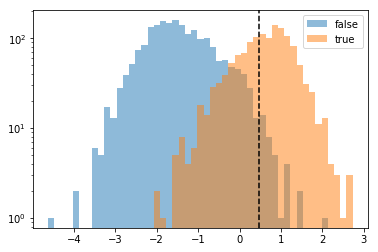

Nuclear membrane 1 0.8571428571428572 0.39347883853616533


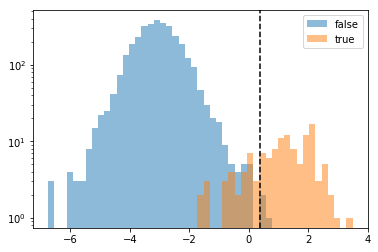

Nucleoli 2 0.7770700636942675 0.3936273471499331


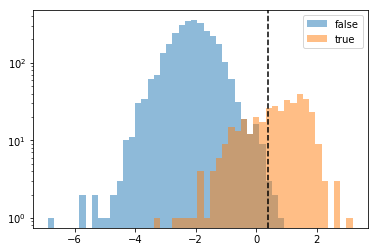

Nucleoli fibrillar center 3 0.7881040892193308 0.4016477474325474


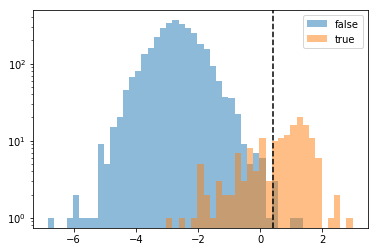

Nuclear speckles 4 0.8194842406876792 0.4102772653248994


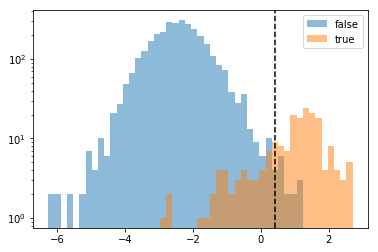

Nuclear bodies 5 0.6400000000000001 0.39554918774455794


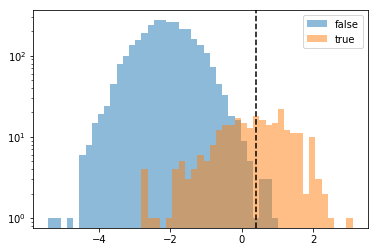

Endoplasmic reticulum 6 0.6777777777777778 0.40755383912700915


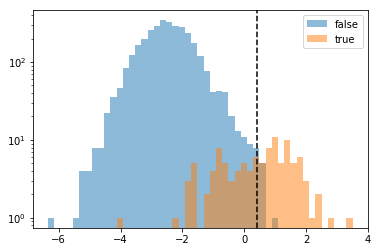

Golgi apparatus 7 0.7875 0.3789155164190182


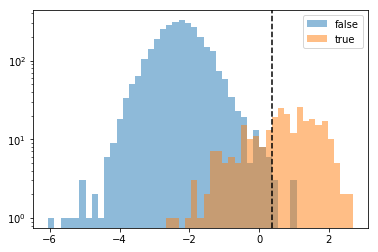

Peroxisomes 8 0.9818181818181818 0.1987651341927853


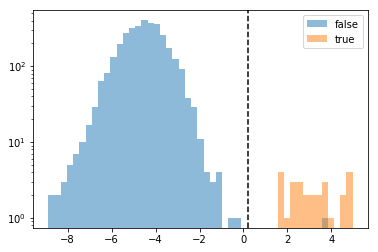

Endosomes 9 0.9615384615384616 0.20400801155604598


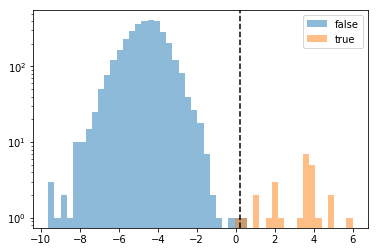

Lysosomes 10 1.0 0.20489590415165404


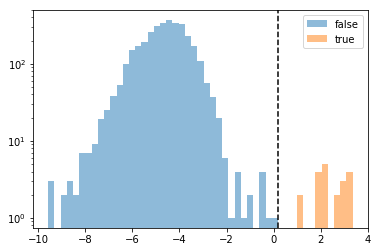

Intermediate filaments 11 0.6931818181818182 0.4047522551942616


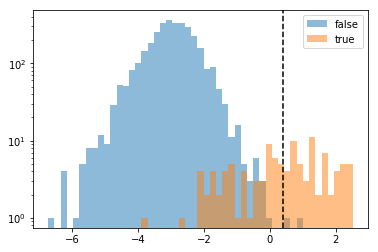

Actin filaments 12 0.7719298245614035 0.41220244354483976


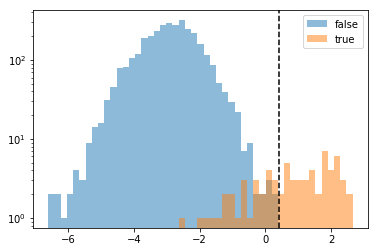

Focal adhesion sites 13 0.7191011235955056 0.3990487679849381


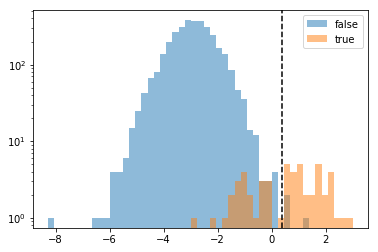

Microtubules 14 0.826923076923077 0.39602283166142677


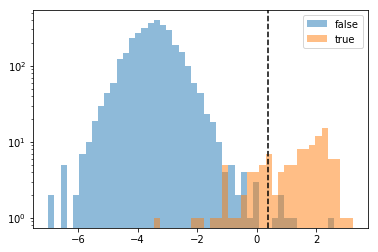

Microtubule ends 15 1.0 0.19881173991027068


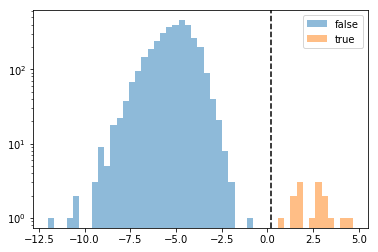

Cytokinetic bridge 16 0.5818181818181819 0.41057172301472855


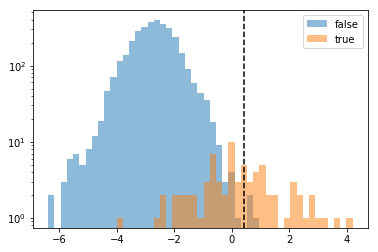

Mitotic spindle 17 0.6666666666666667 0.400025390791242


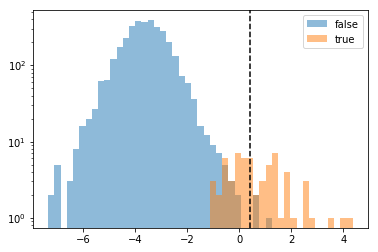

Microtubule organizing center 18 0.5034013605442177 0.4138361069770807


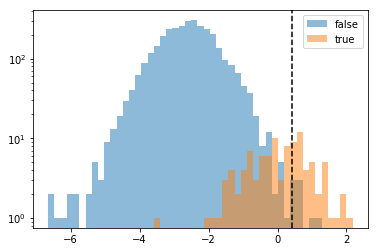

Centrosome 19 0.5185185185185185 0.3999069064127381


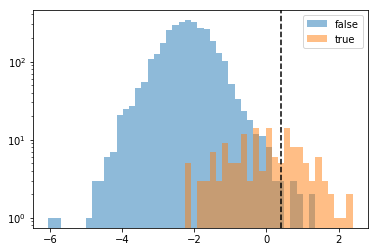

Lipid droplets 20 0.8598130841121494 0.21276502385564477


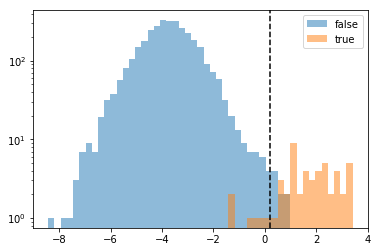

Plasma membrane 21 0.6611570247933883 0.40006029944115584


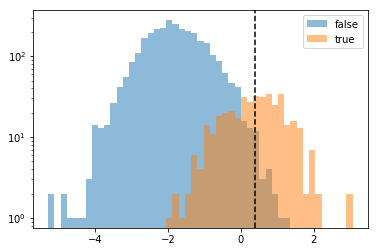

Cell junctions 22 0.5737704918032787 0.39083590504698973


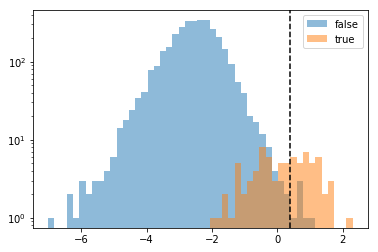

Mitochondria 23 0.7683168316831683 0.39603311683989406


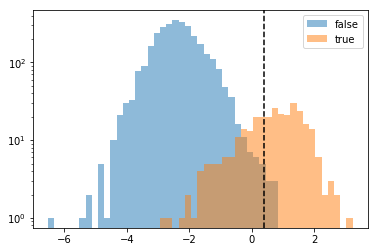

Aggresome 24 0.7976190476190477 0.4021114442289474


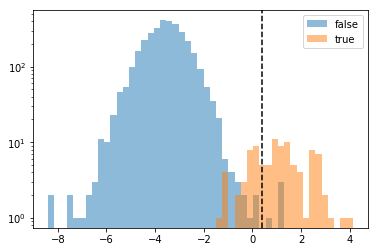

Cytosol 25 0.5544871794871795 0.40247063536893746


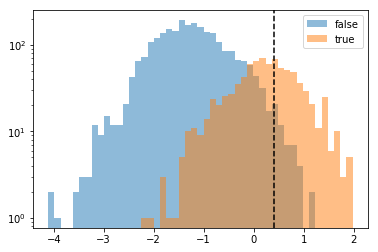

Cytoplasmic bodies 26 0.8333333333333334 0.40805033483895764


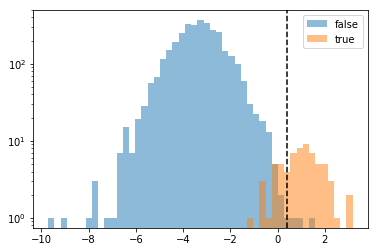

Rods & rings 27 0.8 0.1987334506282925


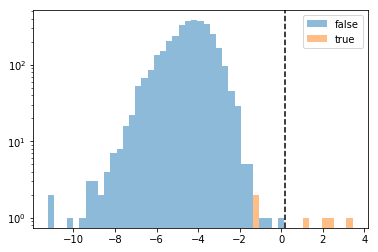

In [75]:
f1 = f1_score(y_np, preds_np>thresh, average=None)
for i in range(len(subcell_locs)):
    bins = np.linspace(preds_np[:,i].min(), preds_np[:,i].max(), 50)
    plt.hist(preds_np[y_np[:,i] == 0][:,i], bins, alpha=0.5, log=True, label='false')
    plt.hist(preds_np[y_np[:,i] == 1][:,i], bins, alpha=0.5, log=True, label='true')
    plt.legend(loc='upper right')
    print(subcell_locs[i],i, f1[i], thresh[i])
    plt.axvline(x=thresh[i], color='k', linestyle='--')
    plt.show()

### predict test set 

In [76]:
preds_t_tta, y_t = learn.TTA(ds_type=DatasetType.Test)

In [77]:
act_preds_t = torch.sigmoid(preds_t_tta)

In [78]:
preds_np = act_preds_t.numpy()

In [81]:
thresh = res.x #* 0.80 #weights.numpy()*0.85

In [154]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>thresh)[0]])) \
               for row in np.array(act_preds_t)]

In [79]:
test_matches = pd.read_csv(path/'test_matches.csv')

In [80]:
test_matches.head()

,Extra,Test,SimR,SimG,SimB,Target,Target_noisey
0,ENSG00000001497_44431_556_B9_1,7729b27c-bacc-11e8-b2b8-ac1f6b6435d0,10,6,2,25 18 0,NaN
1,ENSG00000006194_35086_383_E8_7,5661665e-bacf-11e8-b2b8-ac1f6b6435d0,0,0,0,25 17 0,NaN
2,ENSG00000008324_47377_688_E7_10,b029f372-bad9-11e8-b2b9-ac1f6b6435d0,2,0,2,23 2,NaN
3,ENSG00000019186_63771_1414_D12_2,adc182fa-bad2-11e8-b2b8-ac1f6b6435d0,6,2,0,23 0 21,NaN
4,ENSG00000025770_67932_1255_A3_4,39508fe6-bad3-11e8-b2b8-ac1f6b6435d0,0,0,0,16 0,NaN


## public lb f1 scores:

### using with_external/best/bestmodel_externalres50_4E 

### without leak

- 0.554 filling nulls

- 0.557 not filling nulls thresh * 0.845 (best val thresh)

- 0.555 not filling nulls thresh * 0.9

- 0.558 not filling nulls thresh * 0.8

### with leak

- 0.579 

- 0.568 with one fold

### using 1 fold

- 0.555 thresh * 1, filling nulls: thresh * 0.9

- 0.556 thresh * 0.9

- 0.562 ensamble (0.1, 0.9), thresh ensamble (0.2, 0.8)

### oversampling

- 0.537 lafoss thresh no sigmoid

- 0.515 0 thresh

In [82]:
def save_pred(pred, th=0.0, fname='protein_classification.csv'):        
    pred_list = [' '.join(list([str(i) for i in np.nonzero(row>th)[0]])) \
               for row in np.array(pred)]
    
    loops = 1
    while pred_list.count('') > 0:
        indices = [i for i, x in enumerate(pred_list) if x == '']
        print(pred_list.count(''), loops)

        for ind in indices: 
            pred_list[ind] = ' '.join(list([str(i) for i in np.nonzero(pred[ind]>th-0.05*loops)[0]]))
            
        loops += 1
        
    print(pred_list.count(''), loops)
    
    df = pd.DataFrame({'Id':test_ids,'Predicted':pred_list})
    
    for _, row in test_matches.iterrows():
        #print(df[df.Id == row.Test].Predicted)
        df['Predicted'][df.Id == row.Test] = row.Target
        #print(df[df.Id == row.Test].Predicted)
    
    print(pred_list.count(''))
    df.sort_values(by='Id').to_csv(fname, header=True, index=False)

In [86]:
save_pred(act_preds_t.numpy(),thresh,'resnet50_best.csv')

489 1
148 2
34 3
1 4
0 5
0


### Lafoss thresholding stuff

In [ ]:
def save_pred(pred, th=0.0, fname='protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
    
    df = pd.DataFrame({'Id':learner.data.test_ds.fnames,'Predicted':pred_list})
    df.sort_values(by='Id').to_csv(fname, header=True, index=False)

In [ ]:
save_pred(pred_t,th,'protein_classification_v.csv')
save_pred(pred_t,0.0,'protein_classification_0.csv')

In [ ]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]

In [ ]:
def Count_soft(preds,th=0.0,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = np.zeros(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*p), axis=None)
    p, success = opt.leastsq(error, params)
    return p


In [ ]:
th_t = fit_test(pred_t,lb_prob)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.0): ',(pred_t > 0.0).mean(axis=0))

In [ ]:
save_pred(pred_t,th_t,'protein_classification_f.csv')

In [ ]:
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = th[i]
save_pred(pred_t,th_t,'protein_classification_c.csv')

In [ ]:
th_t = fit_test(pred_t,label_fraction)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,'protein_classification_t.csv')